# Wright-Fisher simulations

*in progress*

## Imports / configuration

In [168]:
import numpy as np
import matplotlib.pyplot as plt
import pylab as pb
import GPy as gp

In [209]:
def simulate_frequencies(p, n_e, max_gen):
    """Simulate frequencies under the Wright Fisher model
    
    Args
    ----
    p : int
        number of SNPs
    n_e : int
        effective population size
    max_gen : int
        maximum number of generations
    
    Returns
    -------
    F : np.array
        max_gen x p matrix
    
    """
    F = np.empty((max_gen, p))
    F[0, :] = np.random.beta(1., 1., size=p)
    for t in range(1, max_gen):
        F[t, :] = np.random.binomial(2 * n_e, F[t-1, :]) / (2 * n_e)
    
    return(F)

def simulate_genotypes(t, F):
    """Simulate sampled genotypes conditional on 
    full allele frequency trajectories
    
    Args
    ----
    
    Returns
    -------
    
    """
    F_samp = F[t, :]
    X = np.random.binomial(2, F_samp)
    
    return(X)

def compute_mean_heterozygosity(X):
    """
    
    Args
    ----
    
    Returns
    -------
    """
    n, p = X.shape
    h_hat = np.sum(X==1, axis=1) / p
    
    return(h_hat)  

## Simulation

In [228]:
p = 20000
n_e = 10000
max_gen = 1000
F = simulate_frequencies(p, n_e, max_gen)
H = 2 * F * (1 - F)
h_mod = H[-1,:]
sigma2_e = np.sum(h_mod * (1. - h_mod)) / p**2
h_true = np.sum(H, axis=1) / p

n = 25
t = np.sort(np.random.choice(range(F.shape[0]), size=n, replace=False))
X = simulate_genotypes(t, F)
h = h_true[t]
h_hat = compute_mean_heterozygosity(X)
#mu = np.mean(h_hat)
#sigma2 = mu * (1 - mu)

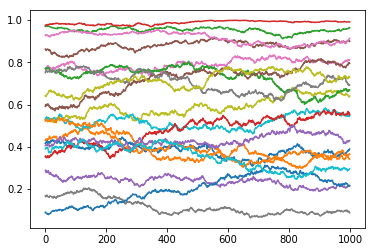

In [229]:
idx = np.sort(np.random.choice(range(p), size=20, replace=False))
for j in idx:
    plt.plot(range(max_gen), F[:,j])

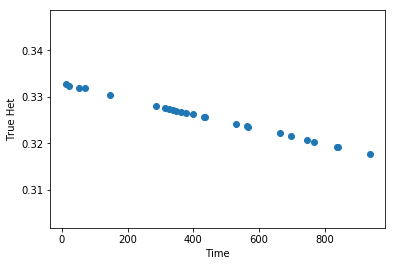

In [230]:
plt.scatter(t, h)
plt.xlabel("Time");
plt.ylabel("True Het");

Text(0,0.5,'Estimted Het')

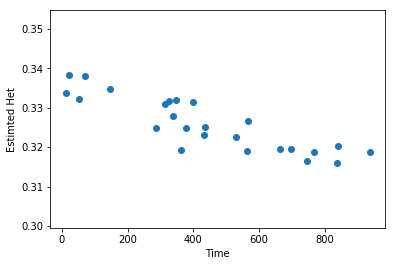

In [231]:
plt.scatter(t, h_hat)
plt.xlabel("Time")
plt.ylabel("Estimted Het")

## Inference

In [244]:
#kern = gp.kern.Exponential(1)
kern = gp.kern.Matern32(1) 
model = gp.models.GPRegression(t[:,None], h_hat[:,None], kern)
model[".*Gaussian_noise"] = sigma2_e 
model['.*Gaussian_noise'].fix()

In [245]:
model.optimize()

## Critique

 /project/jnovembre/jhmarcus/src/miniconda3/envs/gp_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


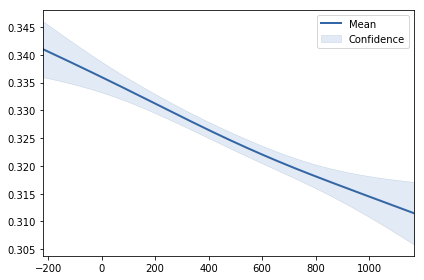

In [246]:
model.plot_f();

0.9990486997080241

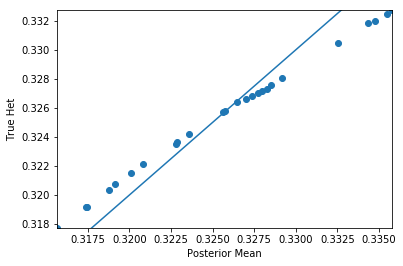

In [247]:
plt.scatter(model.posterior.mean[:,0], h)
plt.plot(np.linspace(0.0,1.,10), np.linspace(0.0,1.,10))
plt.xlabel("Posterior Mean");
plt.ylabel("True Het");
plt.xlim(np.min(model.posterior.mean[:,0]), np.max(model.posterior.mean[:,0]))
plt.ylim(np.min(h), np.max(h))
#plt.axes().set_aspect('equal');
np.corrcoef(model.posterior.mean[:,0], h)[0,1]

0.8759317188180881

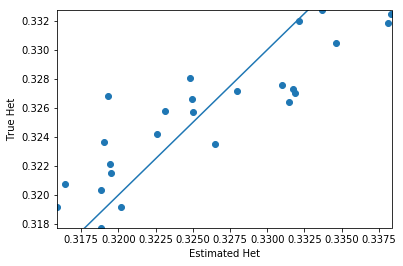

In [248]:
plt.scatter(h_hat, h)
plt.plot(np.linspace(0.0,1.,10), np.linspace(0.0,1.,10))
plt.xlabel("Estimated Het")
plt.ylabel("True Het")
plt.xlim(np.min(h_hat), np.max(h_hat))
plt.ylim(np.min(h), np.max(h))
#plt.axes().set_aspect('equal')
np.corrcoef(h_hat, h)[0,1]

In [249]:
model.kern

Mat32.,value,constraints,priors
variance,0.11556335523867489,+ve,
lengthscale,26433.272218419916,+ve,
